<center><H1>EE 679: Computing Assignment 1</H1>
<H2> Name: Vinit Awale</H2>
<H2> Roll No: 18D070067 </H2>
<H2> Date: 2/9/2020</H2>
</center>

## <b><i> Question 1:</i></b>
 Given the following specification for a single-formant resonator, obtain the transfer function of the filter H(z) from the relation between resonance frequency / bandwidth, and the pole angle / radius.  Plot filter magnitude response (dB magnitude versus frequency) and impulse response.
 
  
<b> F1 (formant) = 900 Hz   </b>     
<b> B1(bandwidth) = 200 Hz    </b>     
<b> Fs (sampling freq) = 16 kHz   </b>    

## <b> Solution: </b>
We can calculate the transfer function using the following equation:
$$ 
H(z) = \frac{1}{1-2rcos \theta z^{-1} + r^2 z^{-2}}
$$

Where $r$ is the magnitude of the pole and $theta$ is the angle of the pole.
$$
    r = e^{-\pi B T} \\
    \theta = 2\pi FT
$$
where, T is the sampling period and F is the frequency of the formant.

Further, to get the transfer function as a function of the frequency, we can substitute z as:
$$
    z = e^{j\omega T} = e^{\frac{j 2\pi f}{Fs} }
$$ 
$$
    \implies H(f) = \left.\frac{1}{1-2rcos \theta z^{-1} + r^2 z^{-2}}\right|_{z = e^{\frac{j 2\pi f}{Fs} } }
$$ 

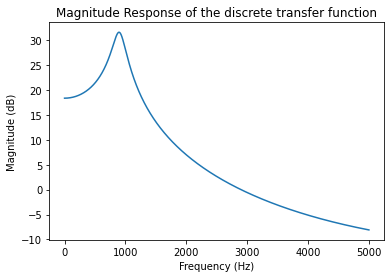

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write

# Input Parameters

F1 = 900
B1 = 200
Fs = 16000

freq_range = np.arange(0,5000,1)

# Function to calculate the transfer function from poles parameters 
def H_discrete_transfer_mag(F1, B1, Fs):
    """ Function to get the discrete transfer function from Formant freq and bandwidth
        
    Args:
        F1 (int): Formant frequency
        B1 (int): Formant bandwidth
        Fs (int): Sampling frequency

    Returns:
        [ndarray]: Magnitude of the discrete transfer function
    """   
    T = 1/Fs                                # Sampling period
    H_discrete = []                         # Empty list to store the discrete transfer function
    r1 = np.exp(-np.pi*B1*T)                # Magnitude of the pole corresponding to the formant 1
    theta1 = 2*np.pi*F1*T                   # Angle of the pole corresponding to the formant 1
    freq_range = np.arange(0,5000,1)        # define the range of frequency values
    
    for f in freq_range:
        z = np.exp(2j*np.pi*f/Fs)           # complex exponential in discrete domain
        H = 1/(1-2*r1*np.cos(theta1)*z**-1 + r1**2*z**-2)  # discrete transfer function calculation
        H_discrete.append(np.abs(H))

    return H_discrete   

H = H_discrete_transfer_mag(F1, B1, Fs)

plt.plot(freq_range, 20* np.log10(H))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Magnitude Response of the discrete transfer function')
plt.show()

## Calculation of the Impulse Response

To calculate the Impulse Response we construct the difference equation from the transfer function.
$$
    H(z) = \frac{1}{1-2rcos \theta z^{-1} + r^2 z^{-2}}
$$
Comparing H(z) with standard form of transfer function
$$
    H(z) = \frac{b_0}{a_0+ a_1 z^{-1} + a_2 z^{-2}}
$$
we get:
$$
    a_0 = 1 \\
    a_1 = -2rcos \theta \\
    a_2 = r^2  \\
    b_0 = 1    
$$
Hence, we can form the difference equation from the transfer function as follows:
$$
    a_0 y[n] + a_1 y[n-1] + a_2 y[n-2] = b_0 x[n] \\
    \implies a_0 y[n] = b_0 x[n] - a_1 y[n-1] - a_2 y[n-2]
$$

Subsituting the values of $a_0$, $a_1$, $a_2$ and $b_0$ in the above equation we get:
$$
    y[n] = x[n] + 2rcos \theta x[n-1] - r^2 x[n-2]
$$


In [9]:
# Function to implement the given filter as a difference equation

def filter(x, F1, B1):
    """ Function to get the output signal when input signal x is passed through filter with Formant Freq F1 and 
    Formant Bandwidth B1

    Args:
        x (ndarray): Input signal
        F1 (int): Formant Frequency
        B1 (int): Formant Bandwidth

    Returns:
        [ndarray]: Output signal
    """
    T = 1/Fs                                # Sampling period
    r1 = np.exp(-np.pi*B1*T)                # Magnitude of the pole corresponding to the formant 1
    theta1 = 2*np.pi*F1*T                   # Angle of the pole corresponding to the formant 1
    y = np.zeros(x.size)                    # Initialize output array

    # Assuming initial reset we get the first two terms of the output as 
    y[0] = x[0]
    y[1] = x[1] + 2*r1*np.cos(theta1)*y[0]

    # The rest of the output is calculated using the difference equation
    for i in range(2, x.size):
        y[i] = x[i] + 2*r1*np.cos(theta1)*y[i-1] - r1**2*y[i-2]

    return y

Now, to calculate the impulse response for the filter with given formant, we pass an impulse through the filter and observe the output.

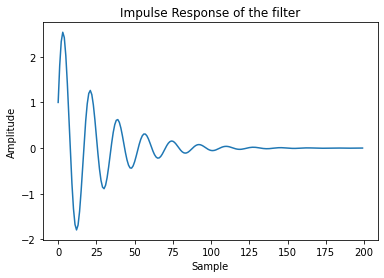

In [10]:
impulse = np.zeros(200)         
impulse[0] = 1                          # Impulse signal

impulse_response = filter(impulse,F1,B1)      # Impulse response of the filter

plt.plot(impulse_response)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Impulse Response of the filter')
plt.show()

## <b><i> Question 2:</i></b>
Excite the above resonator (“filter”) with a periodic source excitation of F0 = 140 Hz. You can approximate the source signal by a narrow-triangular pulse train. Compute the output of the source-filter system over the duration of 0.5 second using the difference equation implementation of the LTI system.  Plot the time domain waveform over a few pitch periods so that you can observe waveform characteristics.  Play out the 0.5 sec duration sound and comment on the sound quality.    

## <b> Solution: </b>
First we make the required periodic source excitation. For this we assume triangular pulse train with a period of 0.5 sec with triangular pulse of frequency 140 Hz.

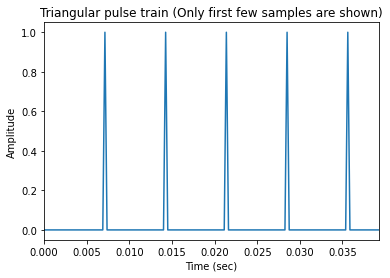

In [11]:
duration = 0.5                                             # Duration of the signal    

F0 = 140                                                   # Impulse frequency
time = np.arange(0, duration, 1/Fs)                        # Time vector
# Function to generate the triangular pulse train with given impulse frequency F0
def triangular_pulse_train_gen(F0, duration, Fs):
    triangular_pulse_train = np.zeros(time.size)           # Empty vector to store the output
    # Generating the triangular pulse train
    for i in range(time.size):
        if i%(Fs//F0) == 0 and i != 0:
            triangular_pulse_train[i] = 1               
            triangular_pulse_train[i+1] = 0.75      
            triangular_pulse_train[i-1] = 0.75      
            triangular_pulse_train[i+2] = 0.5
            triangular_pulse_train[i-2] = 0.5
            triangular_pulse_train[i+3] = 0.25
            triangular_pulse_train[i-3] = 0.25

    return triangular_pulse_train


triangular_pulse_train = triangular_pulse_train_gen(F0, duration, Fs)  # Generating the triangular pulse train for given parameters
    
plt.plot(time, triangular_pulse_train)  # Plot the triangular pulse train
plt.xlim(0,5.5/F0)       # Limit the x-axis to show 5 impulse periods
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.title('Triangular pulse train (Only first few samples are shown)')
plt.show()

Now, we pass this triangular_pulse_train through the filter and observe the output.

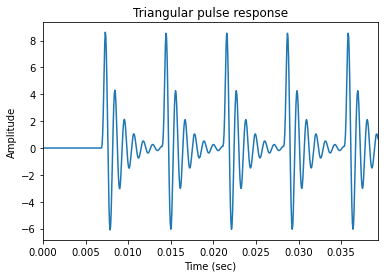

In [12]:
triangular_pulse_response = filter(triangular_pulse_train,F1,B1)  # Pass the triangular pulse train through the filter

plt.plot(time, triangular_pulse_response)                   # Plot the output of the filter
plt.xlim(0,5.5/F0)                           # Limit the x-axis to show 5 impulse periods
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.title('Triangular pulse response')
plt.show()

Now, we play this triangular_pulse_response to observe the sound.

In [13]:
# Write the input sound to input.wav
input_sound = np.int16(triangular_pulse_train/np.max(np.abs(triangular_pulse_train))*32767)
write('input.wav', Fs, input_sound)

# Write the output sound to output.wav
output_sound = np.int16(triangular_pulse_response/np.max(np.abs(triangular_pulse_response))*32767)
write("output.wav",Fs,output_sound)

## <b><i> Question 3:</i></b>
Vary the parameters as indicated below; plot and comment on the differences in waveform and in sound quality for the different parameter combinations.
- <b>F0 = 120 Hz, F1 = 300 Hz, B1 = 100 Hz </b>   
- <b>F0 = 120 Hz, F1= 1200 Hz, B1 = 200 Hz  </b>  
- <b>F0 = 180 Hz, F1 = 300 Hz, B1 = 100 Hz </b>   

## <b> Solution: </b>
### Generate triangular pulse train with period of 0.5 sec and frequencies mentioned above.

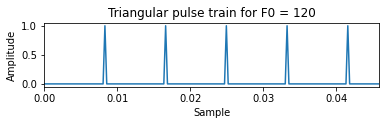

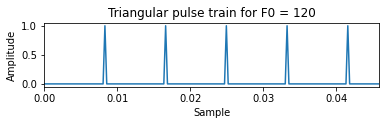

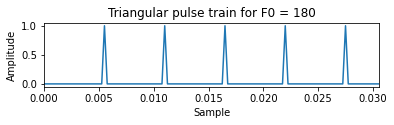

In [14]:
F0s = np.array([120,120,180])               # Array of F0 values

# Generate triangular pulse train with given impulse frequencies F0s
triangular_pulse_trains = [triangular_pulse_train_gen(F0s[i], duration, Fs) for i in range(len(F0s))] 

# Plot the triangular pulse trains for the three cases 
for i in range(len(F0s)):
    plt.subplot(len(F0s),1,i+1)
    plt.plot(time, triangular_pulse_trains[i])
    plt.xlim(0,5.5/F0s[i])
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.title('Triangular pulse train for F0 = ' + str(F0s[i]))
    plt.show()

### Now, lets have a look at the Magnitude of the transfer function for the given three cases

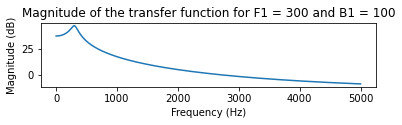

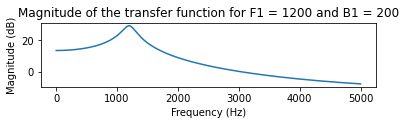

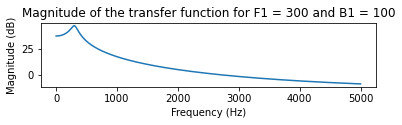

In [15]:
F1s = np.array([300,1200,300])               # Array of F1 values
B1s = np.array([100,200,100])                # Array of B1 values

H_mags = [H_discrete_transfer_mag(F1s[i], B1s[i], Fs) for i in range(len(F1s))]  # Array of H magnitudes

# Plot the Magnitude of the transfer function for the three cases
for i in range(len(F1s)):
    plt.subplot(len(F1s),1,i+1)
    plt.plot(freq_range, 20*np.log10(H_mags[i]))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.title('Magnitude of the transfer function for F1 = ' + str(F1s[i]) + ' and B1 = ' + str(B1s[i]))
    plt.show()

### Now let us see the output of the filter for the given three cases.

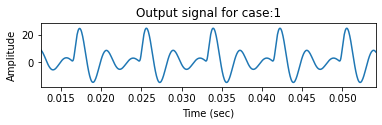

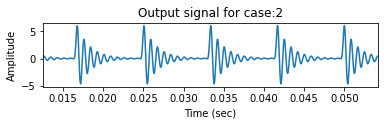

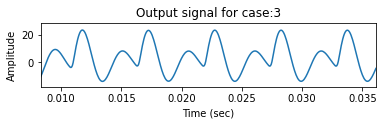

In [18]:
outputs = [filter(triangular_pulse_trains[i],F1s[i],B1s[i]) for i in range(len(F1s))]  # Array of output signals

# Plot the output signals for the three cases
for i in range(len(F1s)):
    plt.subplot(len(F1s),1,i+1)
    plt.plot(time, outputs[i])
    plt.xlim(1.5/F0s[i],6.5/F0s[i])
    plt.xlabel('Time (sec)')
    plt.ylabel('Amplitude')
    plt.title('Output signal for case:'+str(i+1))
    plt.show()

### Now we save the input and output of the filter for the given three cases.

In [17]:
# Write the input sound to input.wav
input_sounds = [np.int16(triangular_pulse_trains[i])*32767 for i in range(len(F1s))] # No need to divide by max since it is 1
for i in range(len(F1s)):
    write('input_'+str(i+1)+'.wav', Fs, input_sounds[i])

# Write the output sound to output.wav
output_sounds = [np.int16(outputs[i]/np.max(np.abs([outputs[i]]))*32767) for i in range(len(F1s))] 
for i in range(len(F1s)):
    write("output_"+str(i+1)+".wav",Fs,output_sounds[i])